
# Clustering de clients

### Importación de librerías 

In [256]:
import pandas as pd 
import numpy as np
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn import metrics
import statsmodels.api as sm

warnings.filterwarnings('ignore')

### Lectura de los datasets

In [258]:
df = pd.read_csv("df_clients_groupby.csv")

In [259]:
df

,yearmonth,brand,sales_without_coupons,sales_monto_with_coupons
0,18,3,16.41464,0.0000
1,18,8,43.83510,1.8873
2,18,8,71.89322,0.0000
3,17,7,11.16268,0.0000
4,18,7,42.95738,0.0000
...,...,...,...,...
28215,15,4,2.90978,0.0000
28216,17,7,8.98948,0.0000
28217,11,5,8.79918,0.0000
28218,16,7,54.65824,0.0000


In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28220 entries, 0 to 28219
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   yearmonth                 28220 non-null  int64  
 1   brand                     28220 non-null  int64  
 2   sales_without_coupons     28220 non-null  float64
 3   sales_monto_with_coupons  28220 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 882.0 KB


In [261]:
df.isna().sum()

yearmonth                   0
brand                       0
sales_without_coupons       0
sales_monto_with_coupons    0
dtype: int64

### Escalado

Efectuamos escalado de los datos para que se encuentran en la misma unidad de medida.

In [264]:
# Preprocessing
features = df.columns

In [265]:
scaler = StandardScaler()
df_escalado = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

In [266]:
df_escalado.head()

,yearmonth,brand,sales_without_coupons,sales_monto_with_coupons
0,0.922416,-1.163034,-0.109193,-0.062057
1,0.922416,1.146795,-0.048910,0.000423
2,0.922416,1.146795,0.012775,-0.062057
3,0.748163,0.684829,-0.120739,-0.062057
4,0.922416,0.684829,-0.050839,-0.062057


## Analisis con Embeddings (conjuntos con alta dimensionalidad)

#### PCA

Aplicamos PCA sobre sobre el conjunto de datos para trabajar solo con aquellas variables que mejor explican la varianza de nuestros datos.

[Documentacion](https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html)

In [269]:
# Fit
pca = PCA (n_components=None)
pca_result = pca.fit_transform(df_escalado)

In [270]:
pca.explained_variance_ratio_.round(2)

array([0.43, 0.25, 0.23, 0.08])

In [271]:
pca_result.shape

(28220, 4)

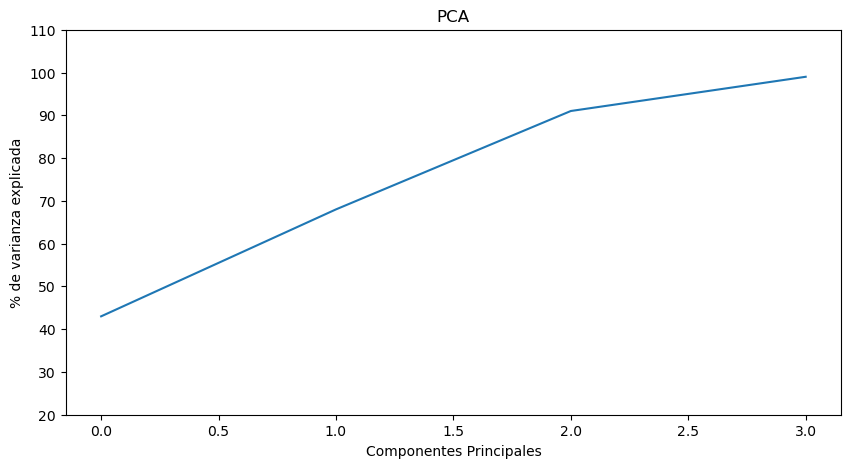

In [272]:
#plt.xticks(range(model['pca'].n_components))

plt.figure(figsize=(10, 5))
plt.ylabel('% de varianza explicada')
plt.xlabel('Componentes Principales')
plt.title('PCA')
plt.ylim(20, 110)
plt.xticks(pca.n_components)
plt.plot(acc_variance_percent)
plt.show()

#### TSNE

Aplicamos TSNE para visualizar nuestros datos en dos dimensiones y asi tener una idea de los grupos que se pueden llegar a formar en el clustering.

[Documentacion](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [275]:
tsne = TSNE(n_components=2, verbose=1,perplexity=8, n_iter=250, init='random', random_state = 15) 

In [276]:
df_tsne = df_escalado

In [277]:
X_tsne_all = tsne.fit_transform(df_tsne)

[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 28220 samples in 0.008s...
[t-SNE] Computed neighbors for 28220 samples in 0.280s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28220
[t-SNE] Computed conditional probabilities for sample 2000 / 28220
[t-SNE] Computed conditional probabilities for sample 3000 / 28220
[t-SNE] Computed conditional probabilities for sample 4000 / 28220
[t-SNE] Computed conditional probabilities for sample 5000 / 28220
[t-SNE] Computed conditional probabilities for sample 6000 / 28220
[t-SNE] Computed conditional probabilities for sample 7000 / 28220
[t-SNE] Computed conditional probabilities for sample 8000 / 28220
[t-SNE] Computed conditional probabilities for sample 9000 / 28220
[t-SNE] Computed conditional probabilities for sample 10000 / 28220
[t-SNE] Computed conditional probabilities for sample 11000 / 28220
[t-SNE] Computed conditional probabilities for sample 12000 / 28220
[t-SNE] Computed conditional probabilities for sam

Graficamos las variables resultantes de TSNE

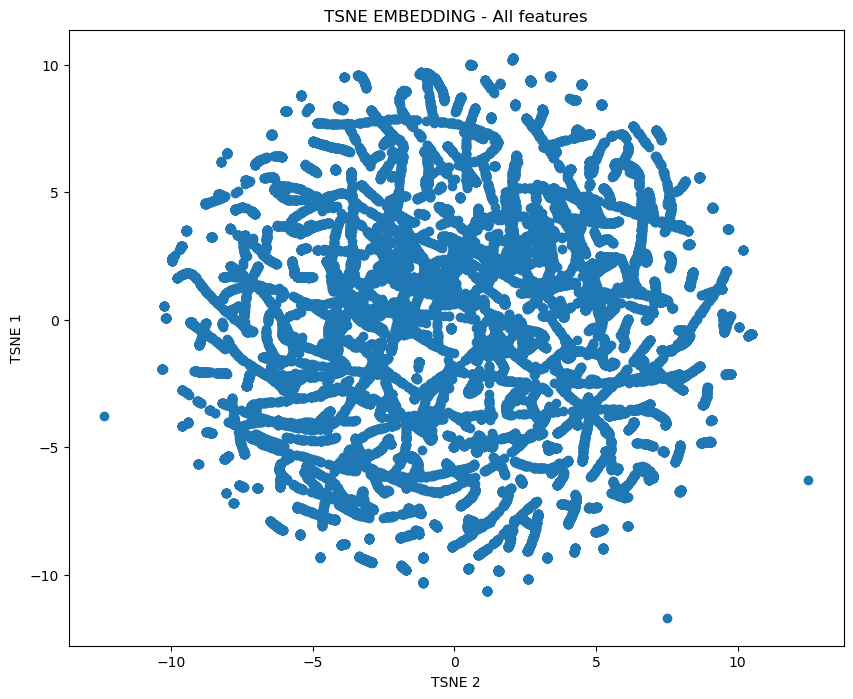

In [279]:
# Plot de resultado en 2 dimensiones
plt.figure(figsize=(10, 8))
plt.ylabel('TSNE 1')
plt.xlabel('TSNE 2')
plt.title('TSNE EMBEDDING - All features')
scatter = plt.scatter(X_tsne_all[:,0], X_tsne_all[:,1])
handles, _ = scatter.legend_elements(prop='colors')

En este gráfico, cada punto representa un cliente. No logramos observar grupos, sino figuras difusas.

# Analisis de Clusters

In [282]:
df_clusters=df_escalado.copy()

## K-Means Clustering

- Inertia o método del codo:  Suma de las distancias de las muestras a su centro de conglomerado más cercano. Se busca minimizar.

- Silhouette score: es la distancia entre una muestra y el grupo más cercano del que la muestra no forma parte. Mide qué tan homogéneos son los clusters, y que tan heterogéneos son entre sí. Se busca maximizar esta métrica. [Documentacion](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

In [285]:
def eleccion_cluster(X_train):
    inertia = []
    silhouet = []
    
    for n in range(2, 15):
        km = KMeans(n_clusters=n, random_state=42).fit(X_train) 
        inertia.append(km.inertia_)
        silhouet.append(silhouette_score(X_train, km.labels_))
    
    fig, axes = plt.subplots(2,1,figsize=(8,8))

    axes[0].plot(np.arange(2, 15), inertia)
    axes[0].set_ylabel("Inertia")
    axes[0].set_title("Inertia of k-Means")
    
    axes[1].plot(np.arange(2, 15), silhouet)
    axes[1].set_ylabel("Silhouet")
    axes[1].set_title("Silhouet score")   

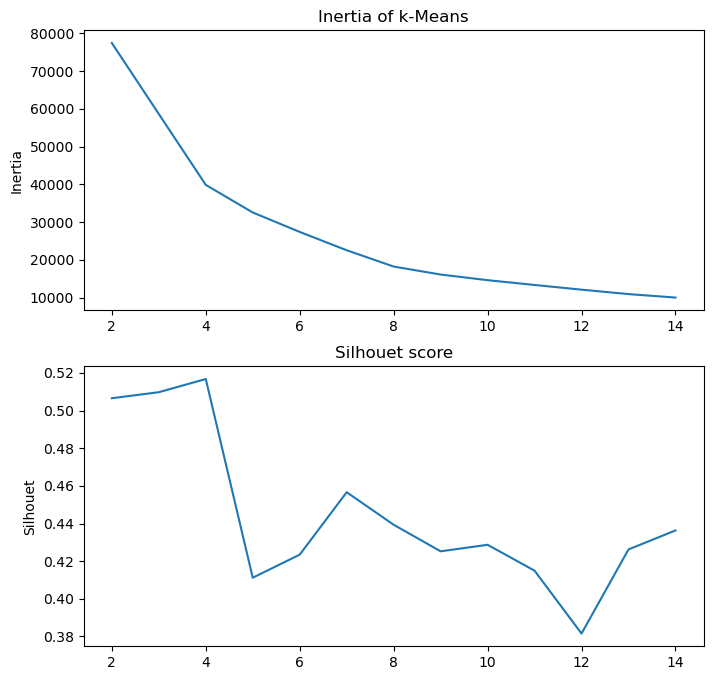

In [286]:
eleccion_cluster(df_clusters)

Se observa una clara caida en la inercia para el numero de cluster 4, y una silueta relativamente alta. Observemos como es la silueta de cada cluster a continuacion

Para n_clusters = 2 El silhouette_score promedio es : 0.5065529359869171
Para n_clusters = 3 El silhouette_score promedio es : 0.5172983129526348
Para n_clusters = 4 El silhouette_score promedio es : 0.5166702062886881
Para n_clusters = 5 El silhouette_score promedio es : 0.4112073875021945
Para n_clusters = 6 El silhouette_score promedio es : 0.41801725404578277


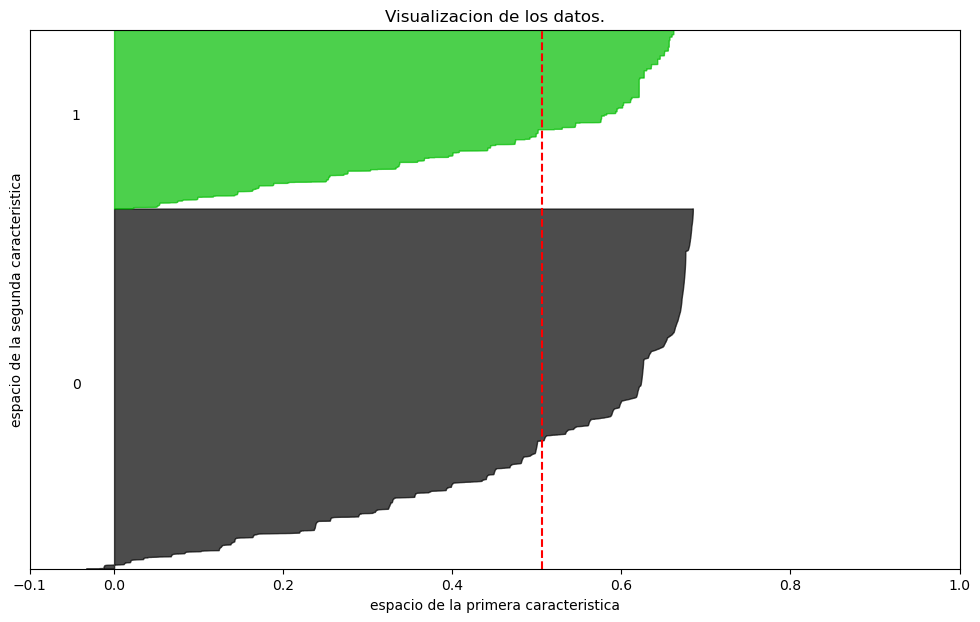

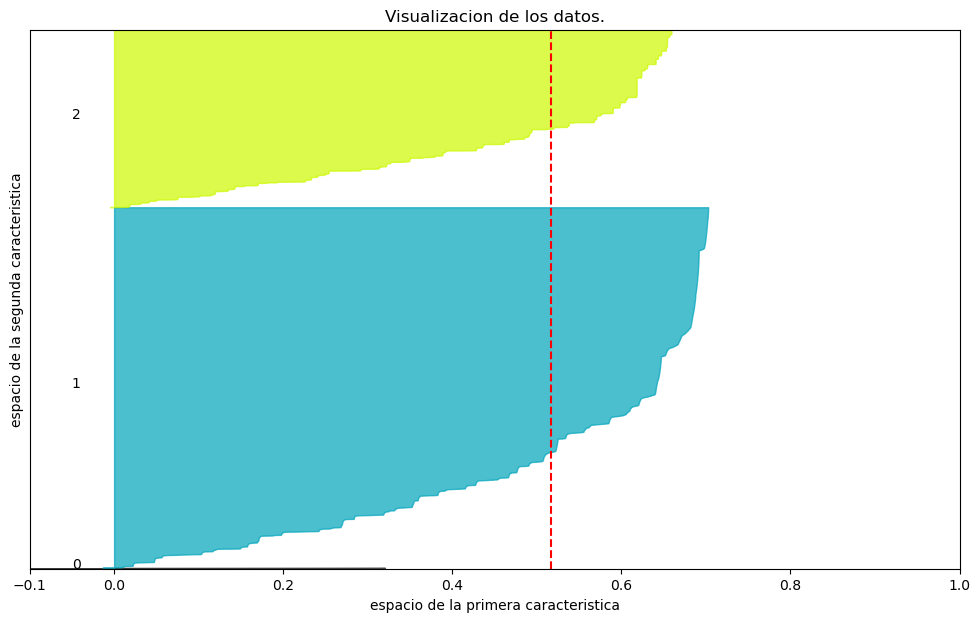

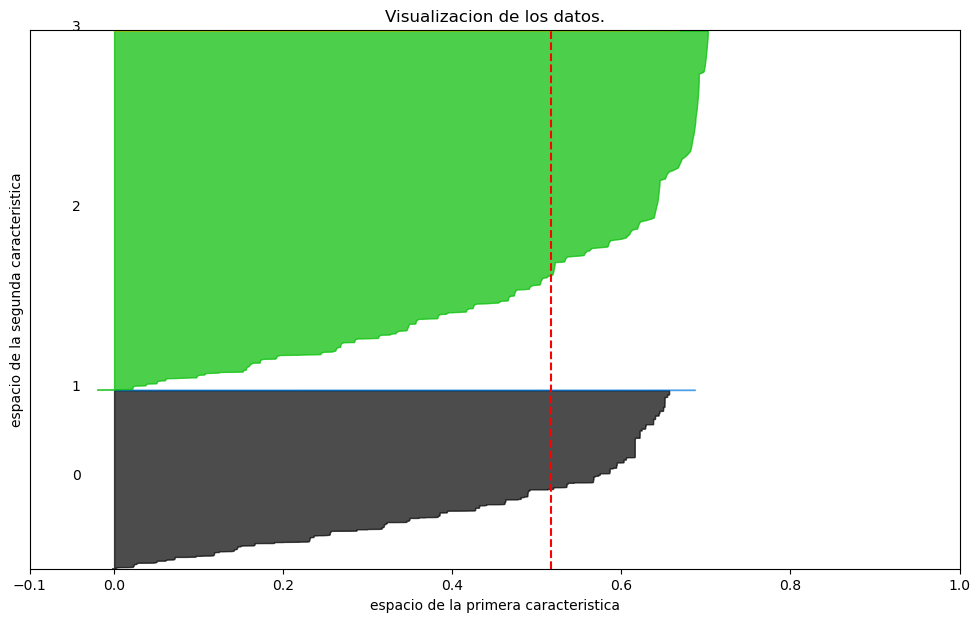

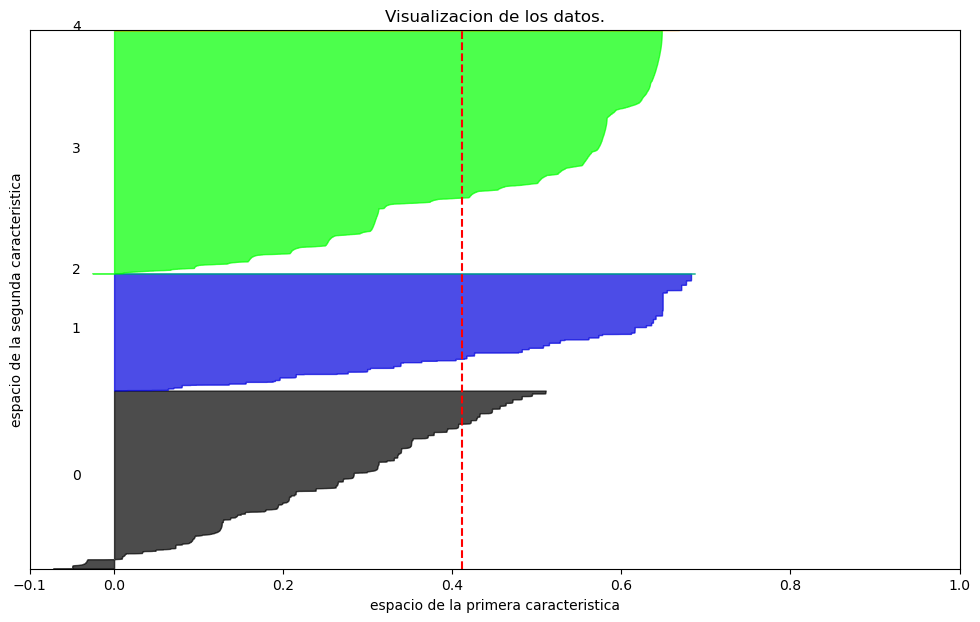

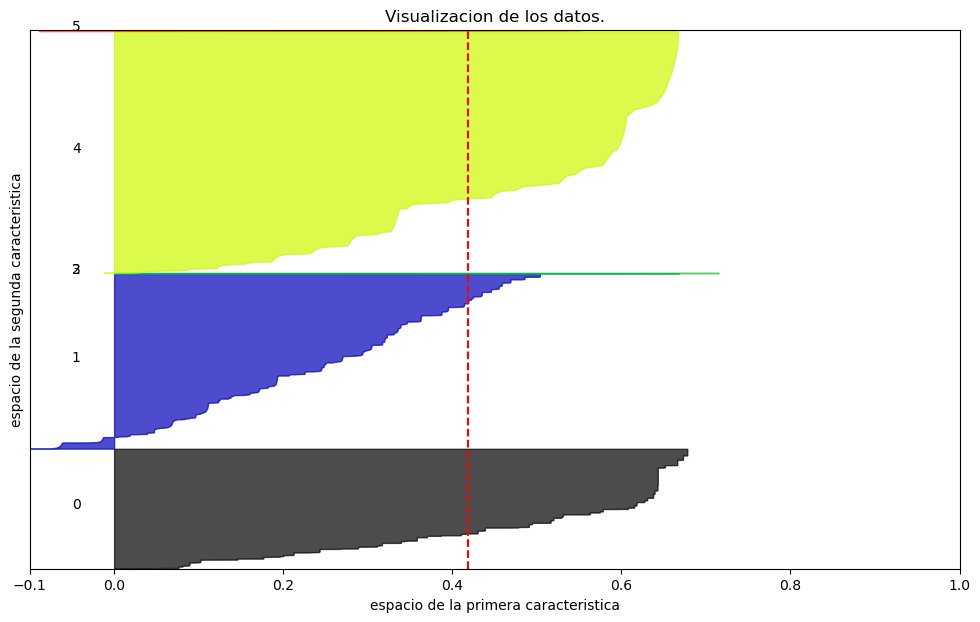

In [288]:
X = df_clusters

range_n_clusters = [2,3,4,5,6]
sse ={}
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(12, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init = 100 )
    cluster_labels = clusterer.fit_predict(X)
    sse[n_clusters] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

Se observan claramente dos grupos diferenciados. 

### Guardado de etiquetas

In [291]:
# Número de clusters buscado
n_clust = 2

km = KMeans(n_clusters=n_clust, random_state=10, n_init = 100 )
km.fit(df_escalado) 
clusters_labels = km.labels_
clusters_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [292]:
len(clusters_labels)

28220

In [293]:
# Armamos columna en df_clusters
df['cluster_kmeans'] = clusters_labels

Observamos cada grupo clusterizado y buscamos encontrar patrones.

In [297]:
df.cluster_kmeans.value_counts()

cluster_kmeans
0    18866
1     9354
Name: count, dtype: int64

In [299]:
df.groupby('cluster_kmeans').describe().T

cluster_kmeans                             0            1
yearmonth                count  18866.000000  9354.000000
                         mean      16.041768     5.979474
                         std        2.704818     4.112838
                         min        4.000000     1.000000
                         25%       15.000000     2.000000
                         50%       17.000000     5.000000
                         75%       18.000000     9.000000
                         max       18.000000    18.000000
brand                    count  18866.000000  9354.000000
                         mean       6.662091     3.209215
                         std        1.326139     1.618467
                         min        2.000000     1.000000
                         25%        6.000000     2.000000
                         50%        7.000000     3.000000
                         75%        8.000000     4.000000
                         max        8.000000     8.000000
sales_without_coupons    count  18866.000000  9354.000000
                         mean      95.558157     6.632820
                         std      552.759808    51.921943
                         min        0.096510    -0.567600
                         25%        9.038380     0.270560
                         50%       23.951340     1.169700
                         75%       64.744815     3.877290
                         max    27287.352580  3844.567000
sales_monto_with_coupons count  18866.000000  9354.000000
                         mean       2.790120     0.027890
                         std       36.908813     0.479309
                         min       -0.037840     0.000000
                         25%        0.000000     0.000000
                         50%        0.000000     0.000000
                         75%        0.000000     0.000000
                         max     2742.586560    19.497220

In [301]:
df[df['sales_monto_with_coupons'] > 0].shape

(2402, 5)

In [303]:
df[df['sales_monto_with_coupons'] > 0].groupby('cluster_kmeans')['sales_monto_with_coupons'].describe().T

cluster_kmeans,0,1
count,2305.000000,97.000000
mean,22.836632,2.689521
std,103.421977,3.892236
min,0.018920,0.028380
25%,0.896760,0.240000
50%,3.860760,1.135200
75%,14.688020,3.021900
max,2742.586560,19.497220


Obserbamos que en la muestra total hay 2402 clientes con ventas con cupones superiores a 0, de los cuales la el 95% se encuentran en el cluster numero 0.

In [306]:
df[df['sales_without_coupons'] > 0].shape

(27924, 5)

In [308]:
df[df['sales_without_coupons'] > 0].groupby('cluster_kmeans')['sales_without_coupons'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
cluster_kmeans,,,,,,,,
0,18866.0,95.56,552.76,0.1,9.04,23.95,64.74,27287.35
1,9058.0,6.85,52.75,0.0,0.34,1.27,4.10,3844.57


Mientras que aquellos clientes con ventas sin cupones mayores a 0, se encuentran distribuidos en los dos clusters, pero de casi el 0.96 de los sujetos que estan el cluster 1 corresponden a este grupo.

Tambien se puede calcular la correlacion promedio de estos grupos. 

In [312]:
df[df['cluster_kmeans'] == 0].T.corr().mean().mean()

0.679292964471675

In [313]:
df[df['cluster_kmeans'] == 1].T.corr().mean().mean()

0.5953126352281158